<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>MCMC </font></h3>
    
    MCMCの計算を行うコードを実行しています。
    Persuasive Python by Adam Fleischhacker 
    https://www.persuasivepython.com/
    
    のコードをライセンスに従って使用しています。
  

/tmp/ipykernel_42/3085080301.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


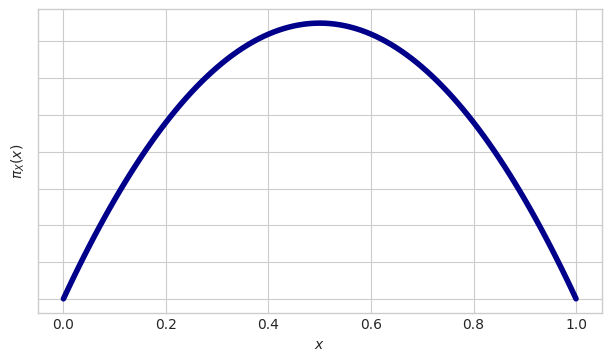

In [1]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

def pi_X(x):
    if x >= 0 and x <= 1:
        return 6*x*(1-x)
    
    else:
        return 0

x = [i/100 for i in range(101)]
y = [pi_X(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_X(x)$')
ax.set_yticklabels([])

plt.show();

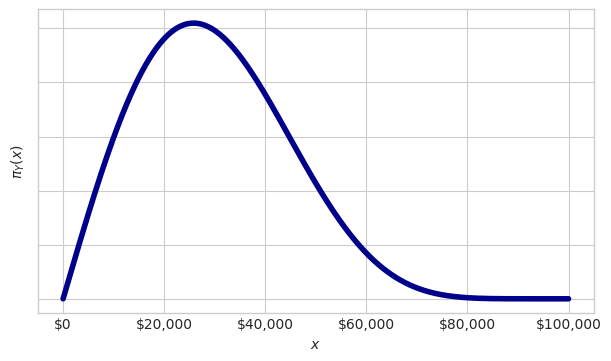

In [2]:
from matplotlib.ticker import FuncFormatter

def pi_Y(y):
    kumaRealization = y / 100000
    jacobian = 1 / 10**5
    if kumaRealization >= 0 and kumaRealization <= 1:
        return 2*8*kumaRealization*(1-kumaRealization**2)**7*jacobian
    else:
        return 0
    
def dollar_format(x, pos):
    """Format y-axis tick Labels in dollar format"""
    return '${:,.0f}'.format(x)

x = [i for i in range(100001)]
y = [pi_Y(i) for i in x]

fig, ax = plt.subplots(figsize=(6, 3.5), layout='constrained')
ax.plot(x, y, color='darkblue', linewidth=4)
ax.set(xlabel=r'$x$', ylabel=r'$\pi_Y(x)$')
ax.xaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_yticklabels([])

plt.show()

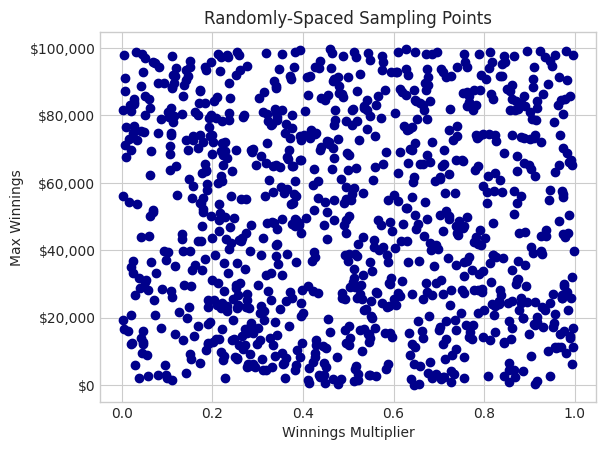

In [3]:
import pandas as pd
import numpy as np

N = 1000 ## 1000でのサンプル

gridDF = pd.DataFrame({'winningsMultiplier': np.random.rand(N),
                       'maxWinnings': 10**5*np.random.rand(N)})

fig, ax = plt.subplots()
ax.scatter(gridDF['winningsMultiplier'], gridDF['maxWinnings'], color='darkblue')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

# 軸ラベルとタイトルを設定
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Randomly-Spaced Sampling Points')

plt.show()

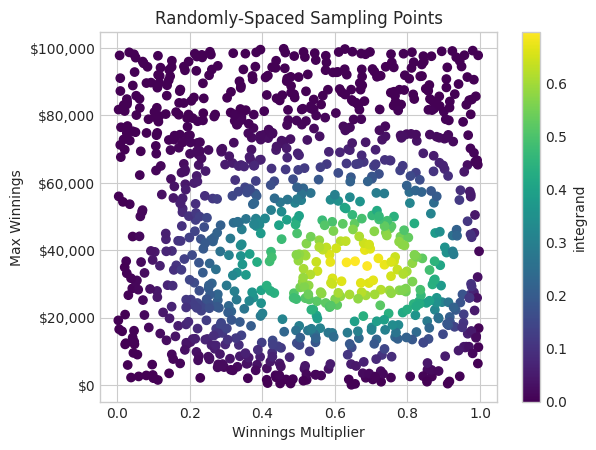

In [4]:
# 積分関数を定義する
def integrandFun(x, y):
    return 3*x**2*y**2 / (3125*10**5)*(1-x)*(1-y**2/10**10)**7

# 上の関数を使ってデータフレームに列を追加する
gridDF['integrand'] = gridDF.apply(lambda row: integrandFun(row['winningsMultiplier'], row['maxWinnings']), axis=1)

fig, ax = plt.subplots()
winPlot = ax.scatter(gridDF['winningsMultiplier'], gridDF['maxWinnings'], c=gridDF['integrand'], cmap='viridis')
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))

# ラベルとタイトルを設定する
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Randomly-Spaced Sampling Points')

fig.colorbar(winPlot, label='integrand')

plt.show()

In [5]:
expectedWinnings = 10**5 * np.mean(gridDF['integrand'])
print("Expected Winnings: " + dollar_format(expectedWinnings, None))

Expected Winnings: $14,857


In [6]:
gridDF.sample(n=10)

,winningsMultiplier,maxWinnings,integrand
899,0.439119,70717.110596,0.040513
598,0.330003,33340.904861,0.341268
60,0.730138,72730.341827,0.037583
175,0.439105,85027.863367,0.000940
444,0.494369,78422.908647,0.009145
875,0.468002,77089.473417,0.012030
939,0.377735,53961.402670,0.223113
120,0.824786,15704.349017,0.236944
351,0.857325,87253.747893,0.000338
321,0.912932,24527.049933,0.271446


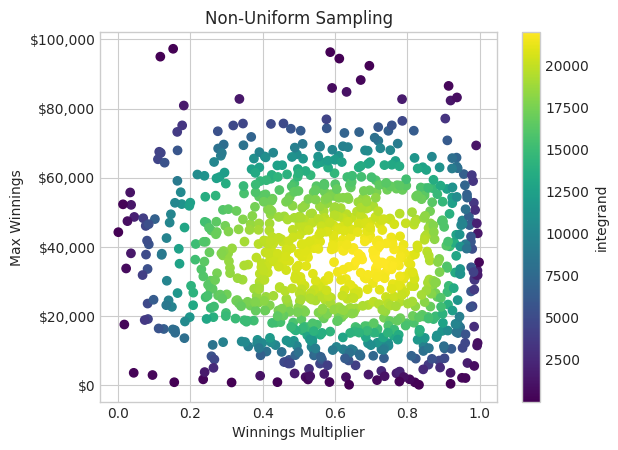

In [7]:
from scipy.stats import truncnorm

## 分布のバウンドは、実際のバウンドではなくsdの範囲内にある

xSamplingDist = truncnorm((0 - 0.65) / 0.3, (1-0.65)/0.3, loc=0.65, scale=0.3) # winnings winningsMultiplier
ySamplingDist = truncnorm((0 - 35000) / 20000, (100000 - 35000) / 20000, loc=35000.0, scale=20000.0) # maxWinnings

# 分布からのサンプル
np.random.seed(123)
n = 1000 
winningsMultiplier = xSamplingDist.rvs(n)
maxWinnings = ySamplingDist.rvs(n)

integrand = integrandFun(winningsMultiplier, maxWinnings) / (xSamplingDist.pdf(winningsMultiplier) * ySamplingDist.pdf(maxWinnings))

# 散布図の作成
fig, ax = plt.subplots()
winPlot = ax.scatter(winningsMultiplier, maxWinnings, c=integrand, cmap='viridis')

# 軸ラベルとタイトルを設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Non-Uniform Sampling')

fig.colorbar(winPlot, label='integrand')
plt.show()

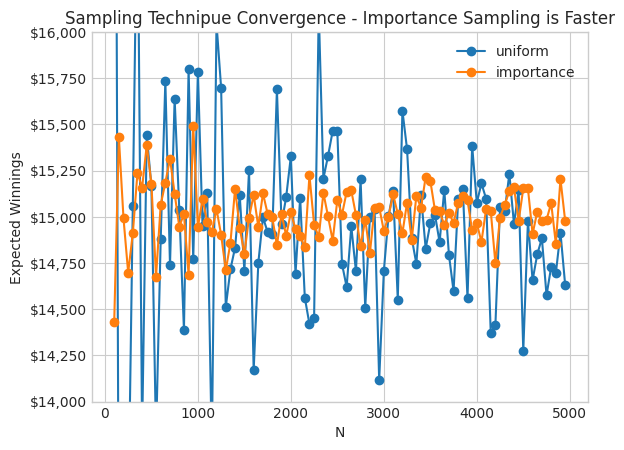

In [8]:
# 収束の比較
N_values = np.arange(100, 5000, step=50)

sim_results = []

def integrandFun2(x, y):
    return integrandFun(x, y) / (xSamplingDist.pdf(x) * ySamplingDist.pdf(y))

for N in N_values:
    # 一様サンプリング
    winningsMultiplier = np.random.rand(N)
    maxWinnings = 10**5 * np.random.rand(N)
    integrand_unif = integrandFun(winningsMultiplier, maxWinnings)
    expWinnings_unif = 10**5 * np.mean(integrand_unif)
    sim_results.append((N, 'uniform', expWinnings_unif))
    
    # 重要度サンプリング
    x_samples = truncnorm.rvs((0 - 0.65) / 0.3, (1 - 0.65) / 0.3, size=N, loc=0.65, scale=0.3)
    y_samples = truncnorm.rvs((0 - 35000) / 20000, (100000 - 35000) / 20000, size=N, loc=35000, scale=20000)
    integrand_imp = integrandFun2(x_samples, y_samples)
    expWinnings_imp = np.mean(integrand_imp)
    sim_results.append((N, 'importance', expWinnings_imp))
    
# 結果のプロット
fig, ax = plt.subplots()
for label in ['uniform', 'importance']:
    x, y = zip(*[(N, expWinnings) for N, method, expWinnings in sim_results if method == label])
    ax.plot(x, y, label=label, marker='o')
    
ax.set_xlabel('N')
ax.set_ylabel('Expected Winnings')
ax.set_title('Sampling Technipue Convergence - Importance Sampling is Faster')
ax.set_ylim(14000, 16000)

ax.yaxis.set_major_formatter(dollar_format)
ax.legend()
plt.show()

In [9]:
# initial point - pick extreme point for illustration
qDF = pd.DataFrame({
    'winningsMultiplier': [0.99],
    'maxWinnings': [99000.0]
})

In [10]:
from numpy.random import default_rng
rng = default_rng(54321)

rng = default_rng(123)
jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 200**2]))

q_current = qDF.iloc[0].to_numpy()
q_proposed = q_current + jumpDist

In [11]:
# パラメータが列として入れられたときのqの密度
def pi_Q(q):
    return pi_X(q[0]) * pi_Y(q[1])

acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
print(acceptanceProb)

1


In [12]:
def addPoint(drawsDF, q_proposed, acceptanceProb):
    if np.random.binomial(1, acceptanceProb):
        drawsDF.loc[drawsDF.index[-1]+1] = q_proposed # 提案された点へ動く
    
    else:
        q = drawsDF.iloc[-1].to_numpy()
        drawsDF.loc[drawsDF.index[-1]+1] = q_current # 同じ点に留まる
        
addPoint(qDF, q_proposed, acceptanceProb)
print(qDF)

   winningsMultiplier  maxWinnings
0            0.990000  99000.00000
1            0.953221  98802.17573


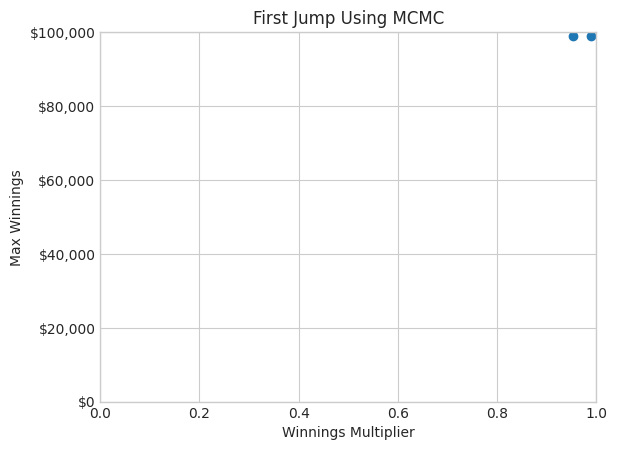

In [13]:
# プロットを作る
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier, qDF.maxWinnings)

# 軸ラベルとタイトルを設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('First Jump Using MCMC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()

In [14]:
for i in range(200):
    jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 200**2]))
    q_current = qDF.iloc[i].to_numpy()
    q_proposed = q_current + jumpDist
    acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
    addPoint(qDF, q_proposed, acceptanceProb)

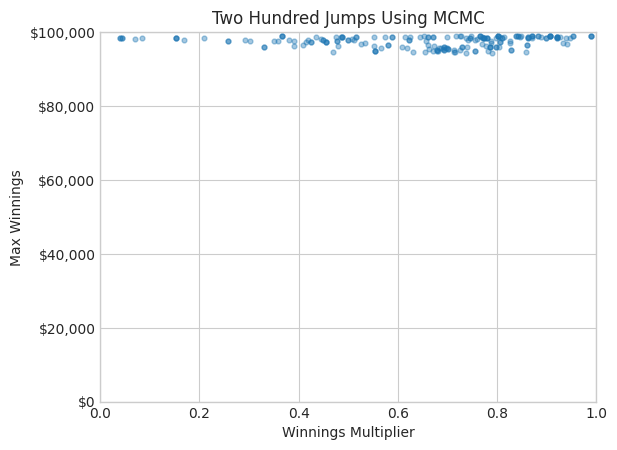

In [15]:
# 散布図をつくる
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier, qDF.maxWinnings, s=12, alpha=0.4)

# 軸ラベルとタイトルの設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Two Hundred Jumps Using MCMC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()

In [16]:
qFirstTryDF = qDF

In [17]:
qDF = pd.DataFrame({
    'winningsMultiplier': [0.99],
    'maxWinnings' : [99000.0]
})

rng = default_rng(123)

for i in range(4000):
    jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 5000**2]))
    q_current = qDF.iloc[i].to_numpy()
    q_proposed = q_current + jumpDist
    acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
    addPoint(qDF, q_proposed, acceptanceProb)

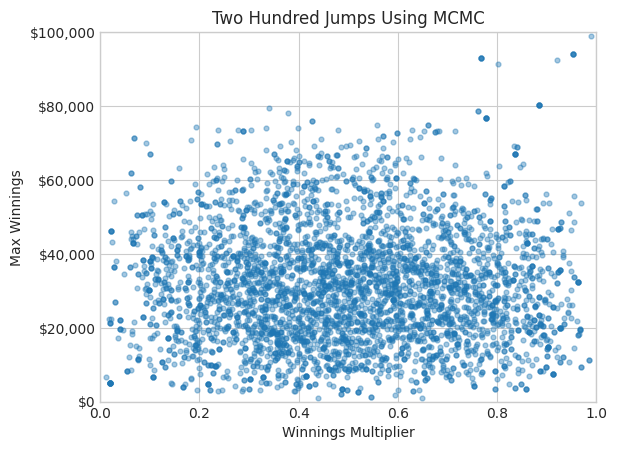

In [18]:
# 散布図をつくる
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier, qDF.maxWinnings, s=12, alpha=0.4)

# 軸ラベルとタイトルの設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Two Hundred Jumps Using MCMC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()

In [19]:
(qDF.winningsMultiplier[200::3]* qDF.maxWinnings[200::3]).mean()

15109.227401450664

In [20]:
qDF = pd.DataFrame({
    'winningsMultiplier' : [0.5],
    'maxWinnings' : [25000.0]
})

rng = default_rng(123)

for i in range(40000): # 40000ドロー
    jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 5000**2]))
    q_current = qDF.iloc[i].to_numpy()
    q_proposed = q_current + jumpDist
    acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
    addPoint(qDF, q_proposed, acceptanceProb)
    
(qDF.winningsMultiplier[1001::3] * qDF.maxWinnings[1001::3]).mean()

15288.808631126894

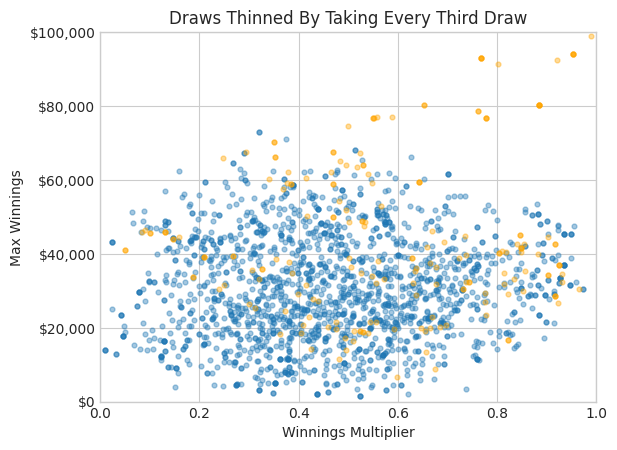

In [21]:
qDF = pd.DataFrame({
    'winningsMultiplier' : [0.99],
    'maxWinnings' : [99000.0]
})

rng = default_rng(123)

for i in range(2000):
    jumpDist = rng.multivariate_normal(np.zeros(2), np.diag([0.1**2, 5000**2]))
    q_current = qDF.iloc[i].to_numpy()
    q_proposed = q_current + jumpDist
    acceptanceProb = min(1, pi_Q(q_proposed) / pi_Q(q_current))
    addPoint(qDF, q_proposed, acceptanceProb)
    
fig, ax = plt.subplots()
ax.scatter(qDF.winningsMultiplier[200:], qDF.maxWinnings[200:], s= 12, alpha = 0.4)
ax.scatter(qDF.winningsMultiplier[:200], qDF.maxWinnings[:200], s= 12, alpha = 0.4, c = "orange")

# 軸ラベルとタイトルを設定
ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))
ax.set_xlabel('Winnings Multiplier')
ax.set_ylabel('Max Winnings')
ax.set_title('Draws Thinned By Taking Every Third Draw')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100000)
plt.show()

In [22]:
!pip install numpyro

  Obtaining dependency information for numpyro from https://files.pythonhosted.org/packages/f9/e1/545f037aa1d119d83bebb6816d9e01138bb2a2ee5878cdd1c1e76fe3a239/numpyro-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 17.3 MB/s eta 0:00:00


sample: 100%|██████████| 1500/1500 [00:02<00:00, 703.25it/s, 3 steps of size 2.74e-01. acc. prob=0.92] 
/opt/conda/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

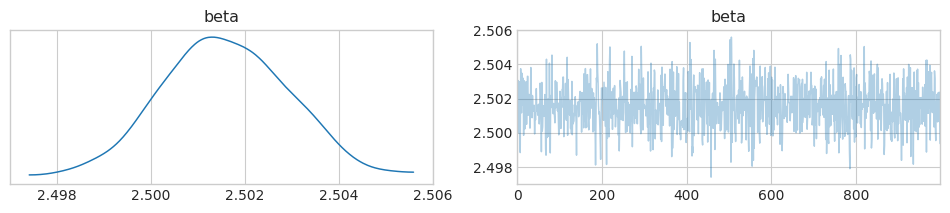

In [23]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az
from jax import random

def model(height, weight):
    # 事前分布とモデルのパラメータを定義
    beta = numpyro.sample('beta', dist.Normal(0, 10))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # 観測データの尤度を定義
    mu = beta * height
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=weight)

# 疑似データの生成
true_beta = 2.5
true_sigma = 1.0
num_samples = 100

# Use a single random key for both height and weight generation
key = random.PRNGKey(0)
height = dist.Normal(70, 2).sample(key, (num_samples,))
weight = dist.Normal(true_beta * height, true_sigma).sample(key)

# MCMCを使ってモデルをフィッティングする
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(2), height=height, weight=weight)

# Convert the NumPy array to xarray DataArray
trace_data = az.from_numpyro(mcmc)

# βのトレースをプロットする
az.plot_trace(trace_data, var_names=['beta'])


In [24]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [25]:
data = np.random.randn(20)

/tmp/ipykernel_42/332884163.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, kde=False, ax=ax)


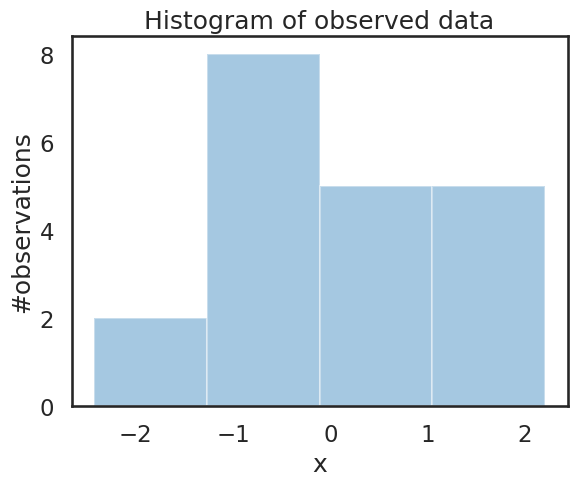

In [26]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x',ylabel='#observations');

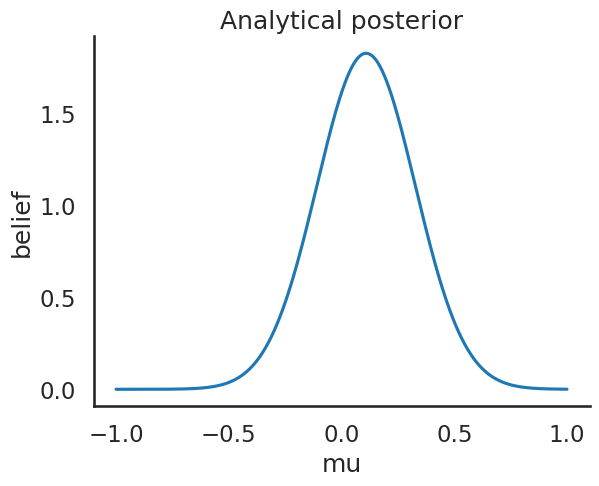

In [27]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() /sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. /sigma_0**2 + n / sigma**2)**(-1)
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [28]:
mu_current = 1

In [34]:
proposal_width = 1.0 

In [35]:
proposal =sp.stats.norm(mu_current, proposal_width).rvs()